<a href="https://colab.research.google.com/github/IoannisPan11/Breast_Tumor_Segmentation/blob/main/breast_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "./drive/My Drive/DIPLOMATIKH/panagiotopoulos_thesis/code/"
#%cd "./drive/My Drive/phd/data/panagiotopoulos_thesis/code/"

In [ ]:
%%capture
!pip install pydicom
!pip3 install git+https://github.com/itzortzis/INBreast_XML_parser.git

In [ ]:
%pwd

In [ ]:
#import anot_core as anot
from anot_core import annotation as anot

import os
import cv2
import csv
import sys
import argparse
import numpy as np
import pydicom as pdcm
from matplotlib import pyplot as plt
import torch
import PIL
import torchvision.transforms as T
import skimage.exposure as skie
%matplotlib inline

# Breast Cancer

In [ ]:
paths = {
    'xml': './INBreast/XML/',
    'dcm': './INBreast/DICOM/',
    'csv': './INBreast/INbreast_compact.csv'
}

args = {
    'p_size': 512,
    'p_step': 50,
    'ppi': 6, # Maximum patchesper image
    'h_ppi': 6
}

In [ ]:
# Build_dcm_dict:
# ---------------
# Given the descriptive csv file of the original
# INBreast dataset, this function generates a dictionary
# with the needed information for each image

# -> path_to_csv: path to the csv file
# <- Dictionary containing the corresponding info

def build_dcm_dict(path_to_csv):
  dcm_list = []

  with open(path_to_csv) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    dict_key   = 0

    for row in csv_reader:
      if line_count == 0:
        line_count += 1
        continue
      obj = {"filename": row[5],
              "mass": row[8],
              "calc": row[9]}
      dcm_list.append(obj)
      line_count += 1
      dict_key += 1
    print(f'Processed {line_count} lines.')

  return dcm_list

obj_list = build_dcm_dict(paths['csv'])

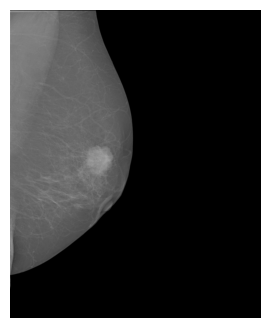

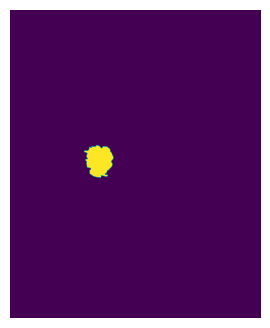

In [ ]:
def create_fig(img_name):

  # Load DICOM file
  path_to_dcm = paths['dcm'] + img_name + '.dcm'
  print(path_to_dcm)
  img_obj = pdcm.dcmread(path_to_dcm)
  img = img_obj.pixel_array

  # Load the corresponding annotation mask
  mask_obj = anot.Annotation(paths['xml'], img_name, img.shape)
  mask = mask_obj.mask

  # Show the original mammogram, the annotation mask and the mask overlaying the mammogram
  #f, axarr = plt.subplots(1)
  #f.set_figheight(4)
  #f.set_figwidth(10)
  #axarr[0].imshow(img, cmap='gray')
  #axarr[0].axis('off')
  #axarr[1].imshow(mask_obj.mask[:, :, 0])
  #axarr[1].axis('off')
  #axarr[2].imshow(img, cmap='gray')
  #axarr[2].imshow(mask_obj.mask[:, :, 0], alpha=0.4)
  #plt.axis('off')
  #plt.show()

  # Show the original mammogram
  plt.figure(figsize=(10, 4))
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.show()
  plt.figure(figsize=(10, 4))
  plt.imshow(mask_obj.mask[:, :, 0])
  plt.axis('off')
  plt.show()



create_fig(obj_list[146]['filename'])
#create_fig(obj_list[254]['filename'])
#create_fig(obj_list[267]['filename'])
#create_fig(obj_list[291]['filename'])

In [ ]:
from skimage.util.dtype import img_as_bool
import cv2
from skimage.transform import rotate
from skimage.exposure import equalize_hist
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.exposure import adjust_gamma
from tqdm import tqdm
import matplotlib.patches as patches
import torchvision.transforms as transforms


def crop(img):

  l = 0
  r = img.shape[1] - 1
  t = 0
  b = img.shape[0] - 1

  while np.sum(img[:, l]) == 0: l += 1
  while np.sum(img[:, r]) == 0: r -= 1
  while np.sum(img[t, :]) == 0: t += 1
  while np.sum(img[b, :]) == 0: b -= 1

  return img[t:b, l:r], l, r, t, b


def resize_img(img, mask, dim):

  resized_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  resized_mask = cv2.resize(mask, dim, interpolation=cv2.INTER_AREA)

  return resized_img, resized_mask


def load_img_mask(img_name):

  path_to_dcm = paths['dcm'] + img_name + '.dcm'
  img_obj = pdcm.dcmread(path_to_dcm)
  img = img_obj.pixel_array

  mask_obj = anot.Annotation(paths['xml'], img_name, img.shape)
  mask = mask_obj.mask

  return img, mask[:, :, 0]


def show_img(img):

  plt.figure()
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.show()


def augment_img_1(img):

  output = equalize_hist(img)

  return output


def augment_img_2(img):

  output = adjust_gamma(img,gamma=0.5,gain=1)

  return output


def augment_img_3(img):

  output = rotate(img, angle=180, resize=True)

  return output


def initialize_dataset(obj_list):

  dataset = np.zeros((len(obj_list), 256, 256, 2))

  for i in tqdm(range(len(obj_list))):

    img_name = obj_list[i]['filename']
    img, mask = load_img_mask(img_name)

    or_img = img
    img = (img - img.min()) / (img.max() - img.min())
    img *= 255
    img = np.uint8(img)

    c_img, l, r, t, b = crop(img)
    c_mask = mask[t:b, l:r]
    r_img, r_mask = resize_img(c_img, c_mask, (256, 256))

    # plt.figure(figsize=(5, 5))
    # plt.imshow(r_img, cmap="gray")
    # plt.show()
    # plt.figure(figsize=(5, 5))
    # plt.imshow(r_mask, cmap="gray")
    # plt.show()

    dataset[i, :, :, 0] = r_img
    dataset[i, :, :, 1] = r_mask

  return dataset


def augmentation_1(dataset):

  aug_dataset_1 = np.zeros((len(obj_list), 256, 256, 2))

  for i in tqdm(range(len(obj_list))):
    aug_img = augment_img_1(dataset[i, :, :, 0])
    aug_dataset_1[i, :, :, 0] = aug_img
    aug_dataset_1[i, :, :, 1] = dataset[i, :, :, 1]

  return aug_dataset_1


def augmentation_2(dataset): # Περιμένει είσοδο με διαστασεις (411, 256, 256, 2)

  aug_dataset_2 = np.zeros((len(obj_list), 256, 256, 2))

  for i in tqdm(range(len(obj_list))):
    aug_img = augment_img_2(dataset[i, :, :, 0])
    aug_dataset_2[i, :, :, 0] = aug_img
    aug_dataset_2[i, :, :, 1] = dataset[i, :, :, 1]

  return aug_dataset_2

def augmentation_3(temp_dataset_2): # Περιμένει είσοδο με διαστασεις (1233, 256, 256, 2)

  aug_dataset_3 = np.zeros((3*len(obj_list), 256, 256, 2))

  for i in tqdm(range(3*len(obj_list))):
    aug_img = augment_img_3(temp_dataset_2[i, :, :, 0])
    aug_mask = augment_img_3(temp_dataset_2[i, :, :, 1])
    aug_dataset_3[i, :, :, 0] = aug_img
    aug_dataset_3[i, :, :, 1] = aug_mask

  return aug_dataset_3

In [ ]:
dataset = initialize_dataset(obj_list)

  7%|▋         | 29/410 [00:32<06:27,  1.02s/it]

./INBreast/XML/22670620.xml


 73%|███████▎  | 299/410 [05:23<02:00,  1.09s/it]

./INBreast/XML/22670094.xml


 82%|████████▏ | 335/410 [06:06<01:44,  1.39s/it]

./INBreast/XML/53587663.xml


100%|██████████| 410/410 [07:24<00:00,  1.08s/it]


In [ ]:
dataset[:, :, :, 0] = (dataset[:, :, :, 0] - np.min(dataset[:, :, :, 0])) / (np.max(dataset[:, :, :, 0]) - np.min(dataset[:, :, :, 0]))

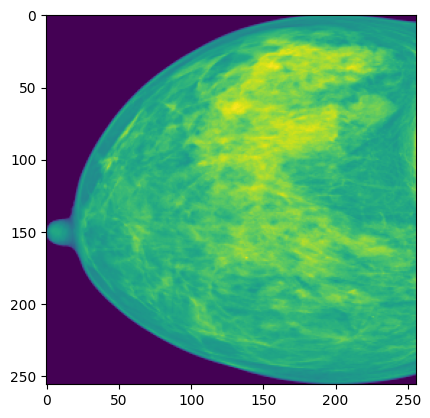

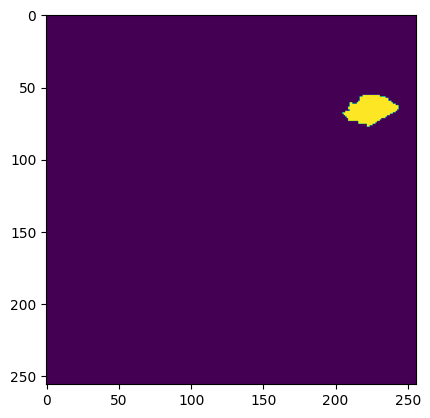

[0. 1.]
(410, 256, 256)
Non-empty masks count: 105
Empty masks count: 305


In [ ]:
w = 11
plt.figure()
plt.imshow(dataset[w, :, :, 0])
plt.show()

plt.figure()
plt.imshow(dataset[w, :, :, 1])
plt.show()

print(np.unique(dataset[w, :, :, 1]))


print(dataset[:, :, :, 1].shape)

non_empty_count = np.sum(np.any(dataset[:, :, :, 1], axis=(1, 2))) # Count the non-empty masks
empty_count = len(dataset[:, :, :, 1]) - non_empty_count # Count the empty masks

print("Non-empty masks count:", non_empty_count)
print("Empty masks count:", empty_count)

In [ ]:
print(dataset.shape)

(410, 256, 256, 2)


In [ ]:
aug_dataset_1 = augmentation_1(dataset)

# 1o Προσωρινό dataset (dataset + aug_dataset_1)
temp_dataset_1 = np.zeros((len(dataset)+len(aug_dataset_1), 256, 256, 2))
temp_dataset_1[:len(dataset), :, :, :] = dataset
temp_dataset_1[len(dataset):, :, :, :] = aug_dataset_1

aug_dataset_2 = augmentation_2(dataset)

# 2o Προσωρινό dataset (1o Προσωρινό dataset + aug_dataset_2)
temp_dataset_2 = np.zeros((len(temp_dataset_1)+len(aug_dataset_2), 256, 256, 2))
temp_dataset_2[:len(temp_dataset_1), :, :, :] = temp_dataset_1
temp_dataset_2[len(temp_dataset_1):, :, :, :] = aug_dataset_2

aug_dataset_3 = augmentation_3(temp_dataset_2)

# Τελικό dataset ()
final_dataset = np.zeros((len(temp_dataset_2)+len(aug_dataset_3), 256, 256, 2))
final_dataset[:len(temp_dataset_2), :, :, :] = temp_dataset_2
final_dataset[len(temp_dataset_2):, :, :, :] = aug_dataset_3

100%|██████████| 1230/1230 [00:06<00:00, 201.88it/s]


# Split final dataset to training, validation and testing set

In [ ]:
final_dataset = dataset

In [ ]:
print(final_dataset.shape)

(2460, 256, 256, 2)


In [ ]:
# Dataset after random permutation
rp = np.random.permutation(final_dataset.shape[0])
p_dataset = final_dataset[rp]
print(p_dataset.shape)

(2460, 256, 256, 2)


In [ ]:
training_set_size = int(0.7 * (len(p_dataset)))
validation_set_size = int(0.2 * (len(p_dataset)))
testing_set_size = int(0.1 * (len(p_dataset)))

train_start = 0
train_end = training_set_size
valid_start = train_end
valid_end = valid_start + validation_set_size
test_start = valid_end
test_end = test_start + testing_set_size

training_set = p_dataset[train_start:train_end, :, :, :]
validation_set = p_dataset[valid_start: valid_end, :, :, :]
testing_set = p_dataset[test_start: test_end, :, :, :]

print("Training set: ", training_set.shape)
print("Validation set: ", validation_set.shape)
print("Testing set: ", testing_set.shape)

Training set:  (1722, 256, 256, 2)
Validation set:  (492, 256, 256, 2)
Testing set:  (246, 256, 256, 2)


# Loaders

In [ ]:
import torch

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, dataset):
        self.dataset = dataset

  def __len__(self):
        return len(self.dataset)

  def __getitem__(self, index):
        x = self.dataset[index, :, :, 0]
        y = self.dataset[index, :, :, 1]

        x = torch.from_numpy(x)
        y = torch.from_numpy(y)

        return x, y


train = Dataset(training_set)
params = {'batch_size': 7, 'shuffle': True}
training_generator = torch.utils.data.DataLoader(train, **params)
print("Number of batches (training): ", len(training_generator))

valid = Dataset(validation_set)
params = {'batch_size': 7, 'shuffle': False}
validation_generator = torch.utils.data.DataLoader(valid, **params)
print("Number of batches (validation): ", len(validation_generator))

test = Dataset(testing_set)
params = {'batch_size': 7, 'shuffle': False}
testing_generator = torch.utils.data.DataLoader(test, **params)
print("Number of batches (testing): ", len(testing_generator))

Number of batches (training):  246
Number of batches (validation):  71
Number of batches (testing):  36


# The UNET model

In [ ]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        return expand

# Metrics

In [ ]:
%%capture
!pip install torchmetrics
from torchmetrics import Dice

In [ ]:
# Na vreis tis diafores micro, macro, weighted...
def calculate_dice(preds, targets):
		preds = preds.cpu()
		targets = targets.cpu()
		preds = torch.argmax(preds, dim=1)
		preds = preds.view(-1)
		targets = targets.view(-1)
		dice = Dice(average='macro', num_classes=2)
		d = dice(preds, targets)
		return d

# Training Loop

In [ ]:
import numpy as np

max_epochs = 50
in_channels = 1
out_channels = 2

unet = UNET(in_channels, out_channels)
loss_fn = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.001)

training_f1 = np.zeros((max_epochs, 1))
training_loss = np.zeros((max_epochs, 1))
validation_f1 = np.zeros((max_epochs, 1))
validation_loss = np.zeros((max_epochs, 1))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
unet = unet.to(device)

print("Number of batches (training): ", len(training_generator))
print("Number of batches (validation): ", len(validation_generator))

'''Training'''
for epoch in tqdm(range(max_epochs)):
  print()
  f1_sum = 0 #Reset f1_sum to 0 at the start of each epoch

  for x, y in training_generator:
    x = torch.unsqueeze(x, 1)
    x = x.to(torch.float32)
    y = y.to(torch.int64)

    x = x.to(device)
    y = y.to(device)

    opt.zero_grad()
    predictions = unet(x)
    loss = loss_fn(predictions, y)
    loss.backward()
    opt.step()

    f1 = calculate_dice(predictions, y)
    f1 = f1.item()
    f1_sum += f1  # Accumulate the f1 values

  batch_mean_f1 = f1_sum/len(training_generator)
  training_f1[epoch] = batch_mean_f1
  training_loss[epoch] = loss.item()
  print("Batch mean of f1 (training): {:.6f}".format(float(training_f1[epoch])))


  '''Validation'''
  f1_sum = 0  # Reset f1_sum to 0 for validation
  for x, y in validation_generator:
    x = torch.unsqueeze(x, 1)
    x = x.to(torch.float32)
    y = y.to(torch.int64)

    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
      outputs = unet(x)
      loss = loss_fn(outputs, y)

      f1 = calculate_dice(outputs, y)
      f1 = f1.item()
      f1_sum += f1 #Accumulate the f1 values

  batch_mean_f1 = f1_sum / len(validation_generator)
  validation_f1[epoch] = batch_mean_f1
  validation_loss[epoch] = loss.item()
  print()
  print("Batch mean of f1 (validation): {:.6f}".format(float(validation_f1[epoch])))

In [ ]:
print("Number of batches (testing): ", len(testing_generator))

f1_sum = 0  # Reset f1_sum to 0 for validation
for x, y in testing_generator:
  x = torch.unsqueeze(x, 1)
  x = x.to(torch.float32)
  y = y.to(torch.int64)

  x = x.to(device)
  y = y.to(device)

  with torch.no_grad():
    outputs = unet(x)

    #test = torch.argmax(outputs, dim=1)
    #test = test.cpu().detach().numpy()
    #plt.figure()
    #plt.imshow(y.cpu().detach().numpy()[1, :, :])
    #plt.show()

    #plt.figure()
    #plt.imshow(test[1, :, :])
    #plt.show()
    loss = loss_fn(outputs, y)
    #print("This is the loss value: ", loss.item())

    f1 = calculate_dice(outputs, y)
    f1 = f1.item()
    #print("F1 batch: ", f1)
    f1_sum += f1 #Accumulate the f1 values

#print("Sum of f1: ", f1_sum) #Output the sum of f1

# Ypologismos toy mesou f1 olwn twn batches: batch_mean_f1
batch_mean_f1 = f1_sum / len(testing_generator)
testing_f1 = batch_mean_f1
print("Batch mean of f1 (testing): {:.6f}".format(float(testing_f1)))
test_f1 = np.zeros((1))
test_f1[0] = testing_f1

Number of batches (testing):  36
Batch mean of f1 (testing): 0.637806


In [ ]:
print(training_f1.shape)
print(test_f1)

(50, 1)
[0.63780632]


In [ ]:
import numpy as np
import time
import calendar
current_GMT = time.gmtime()
timestamp = calendar.timegm(current_GMT)
print(timestamp)
exp = 'epochs50_FinalDataset_slr'
np.save(exp + '/Training_f1_' + str(timestamp),training_f1)
np.save(exp +'/Validation_f1_' + str(timestamp),validation_f1)
np.save(exp +'/Training_loss_' + str(timestamp),training_loss)
np.save(exp +'/Validation_loss_' + str(timestamp),validation_loss)
np.save(exp +'/Testing_f1_' + str(timestamp),test_f1)

1699756592


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

fig, axs =  plt.subplots(2, 3)
fig.set_figheight(11)
fig.set_figwidth(23)
axs[0, 0].plot(training_f1, 'tab:orange')
axs[0, 0].set_title("Training")
axs[1, 0].plot(training_loss, 'tab:orange')
axs[1, 0].set_title("Training")
axs[0, 1].plot(validation_f1, 'tab:blue')
axs[0, 1].set_title("Validation")
axs[1, 1].plot(validation_loss, 'tab:blue')
axs[1, 1].set_title("Validation")
axs[0, 2].plot(training_f1, 'tab:orange')
axs[0, 2].plot(validation_f1, 'tab:blue')
axs[0, 2].set_title("Training, Validation")
for ax in axs.flat:
    ax.set(xlabel='Epochs', ylabel='Percentage')
    axs[1, 2].plot(training_loss, 'tab:orange')
axs[1, 2].plot(validation_loss, 'tab:blue')
axs[1, 2].set_title("Training, Validation")
for ax in axs.flat:
    ax.set(xlabel='Epochs', ylabel='Percentage')
plt.show()

In [ ]:
# Theloume argmax sigoura (uparxei periptwsh na ulopoieitai sthn loss function)? An nai, tote pws tha to kanoume.
    '''If I am using the CrossEntropyLoss() function to calculate the loss, then I dont have to apply argmax to the predictions tensor.
    The CrossEntropyLoss() function automatically applies the softmax function to the output tensor before calculating the loss.
    But, if I want to get the predicted class labels for each pixel in the output of the model, I will need to apply argmax to the predictions tensor.
    The argmax function returns the index of the maximum value in a tensor along a specified axis. In the case of a classification problem with
    out_channels classes, applying argmax to the output tensor along the out_channels dimension will give you the predicted class label for each pixel.'''

In [ ]:
r = 0

for r in range(len(dataset)):
  f, axarr = plt.subplots(1,4)
  f.set_figheight(20)
  f.set_figwidth(20)
  axarr[0].imshow(dataset[r, :, :, 0], cmap='gray')
  axarr[0].axis('off')
  axarr[1].imshow(dataset[r, :, :, 1], alpha=1)
  axarr[1].axis('off')
  axarr[2].imshow(dataset[r, :, :, 0], cmap='gray')
  axarr[2].imshow(dataset[r, :, :, 1], alpha=0.35)
  axarr[2].axis('off')

  plt.axis('off')
  plt.show()

In [ ]:
  # Show the original mammogram, the annotation mask and the mask overlaying the mammogram
  f, axarr = plt.subplots(1,3)
  f.set_figheight(4)
  f.set_figwidth(10)
  axarr[0].imshow(dataset[24, :, :, 0], cmap='gray')
  axarr[0].axis('off')
  axarr[1].imshow(dataset[24, :, :, 1])
  axarr[1].axis('off')
  axarr[2].imshow(dataset[24, :, :, 0], cmap='gray')
  axarr[2].imshow(dataset[24, :, :, 1], alpha=0.35)
  plt.axis('off')
  plt.show()

In [ ]:
r = 0

for r in range(len(dataset)):
  f, axarr = plt.subplots(1,4)
  f.set_figheight(20)
  f.set_figwidth(20)
  axarr[0].imshow(dataset[r, :, :, 0], cmap='gray')
  axarr[0].imshow(dataset[r, :, :, 1], alpha=0.3)
  axarr[0].axis('off')
  axarr[1].imshow(aug_dataset_1[r, :, :, 0], cmap='gray')
  axarr[1].imshow(aug_dataset_1[r, :, :, 1], alpha=0.3)
  axarr[1].axis('off')
  axarr[2].imshow(aug_dataset_2[r, :, :, 0], cmap='gray')
  axarr[2].imshow(aug_dataset_2[r, :, :, 1], alpha=0.3)
  axarr[2].axis('off')
  axarr[3].imshow(aug_dataset_3[r, :, :, 0], cmap='gray')
  axarr[3].imshow(aug_dataset_3[r, :, :, 1], alpha=0.3)
  axarr[3].axis('off')
  plt.axis('off')
  plt.show()

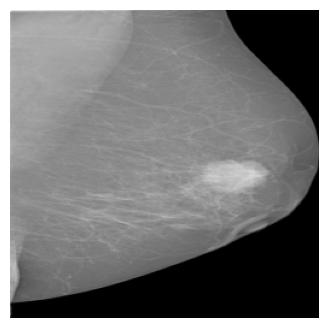

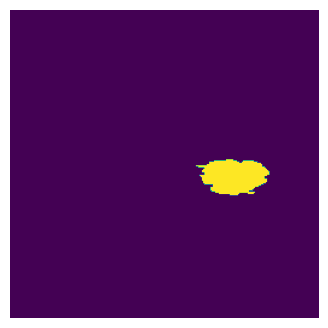

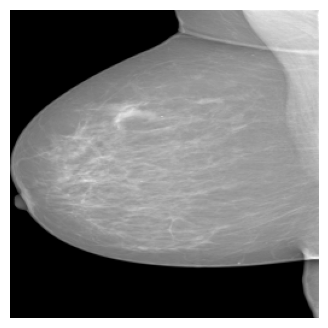

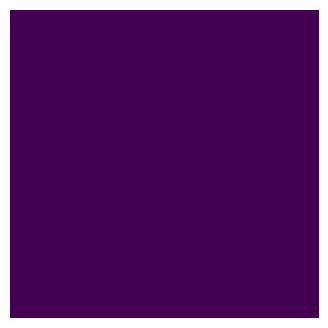

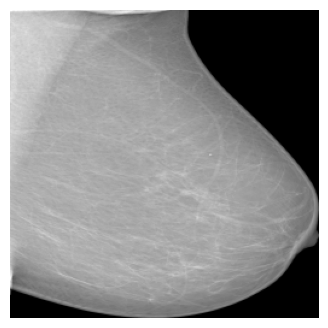

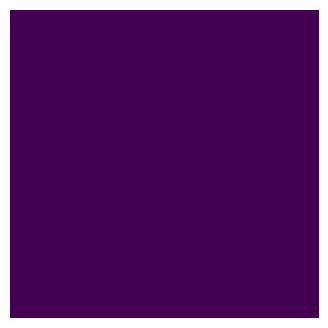

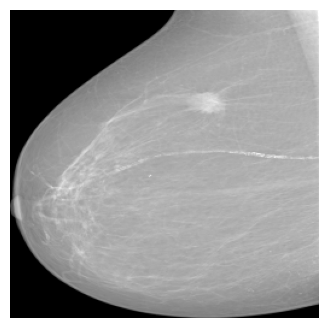

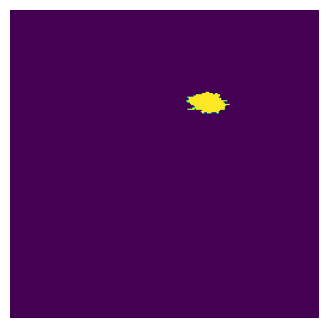

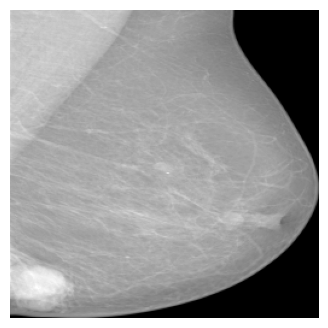

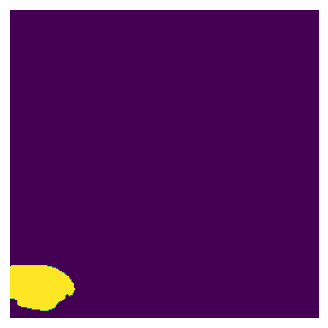

In [ ]:
def create_fig1(r):

  #Show the original mammogram
  plt.figure(figsize=(10, 4))
  plt.imshow(dataset[r, :, :, 0], cmap='gray')
  plt.axis('off')
  plt.show()

  #plt.figure(figsize=(10, 4))
  #plt.imshow(aug_dataset_1[r, :, :, 0], cmap='gray')
  #plt.axis('off')
  #plt.show()

  #plt.figure(figsize=(10, 4))
  #plt.imshow(aug_dataset_2[r, :, :, 0], cmap='gray')
  #plt.axis('off')
  #plt.show()

  #plt.figure(figsize=(10, 4))
  #plt.imshow(aug_dataset_3[r, :, :, 0], cmap='gray')
  #plt.axis('off')
  #plt.show()

  plt.figure(figsize=(10, 4))
  plt.imshow(dataset[r, :, :, 1], alpha=1)
  plt.axis('off')
  plt.show()

create_fig1(146)
create_fig1(254)
create_fig1(267)
create_fig1(291)
create_fig1(105)